In [2]:
import os
os.environ['HF_ENDPOINT']="https://hf-mirror.com"
import torch
from transformers import pipeline
from diffusers import (
    DiffusionPipeline,
    StableDiffusionPipeline,
    ControlNetModel,
    StableDiffusionControlNetPipeline,
    StableDiffusionControlNetInpaintPipeline,
    StableDiffusionImg2ImgPipeline,
    ControlNetModel,
    UniPCMultistepScheduler,
    # AutoPipelineForText2Image ,
    # AutoPipelineForImage2Image
)
from diffusers.utils import load_image
from torchvision.utils import make_grid
import time
from urllib.request import getproxies
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageOps

getproxies()
default_cache_path = os.path.join("D:\\huggingface\\hub\\")
os.environ["CURL_CA_BUNDLE"] = ""
image_filename_list = []
src_image_dir = "../src/img/"
output_image_dir = "../output/image/"
print("torch cuda =", torch.cuda.is_available())

torch cuda = True


In [7]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [8]:
def run_pipe( # run pipline
    pipe, prompt: str, batch_size=1, pref="image", dir=output_image_dir, **kwargs
):
    image_filename_list = []
    seed = [int(np.random.random() * 100000000000000000) for i in range(batch_size)]
    generator = [torch.Generator("cuda").manual_seed(i) for i in seed]
    prompts = batch_size * [prompt]

    kw = {
        "prompt": prompts,
        "generator": generator,
    }
    for key in kwargs:
        kw[key] = [kwargs[key] for i in range(batch_size)]
    images = pipe(**kw).images
    for i in range(batch_size):
        image_filename_list.append(
            dir
            + pref
            + "_"
            + time.time().__int__().__str__()
            + "_seed_"
            + str(seed[i])
            + ".png"
        )
        images[i].save(image_filename_list[-1])
    return image_filename_list

In [9]:
models = [
    "emilianJR/chilloutmix_NiPrunedFp32Fix",
    "CompVis/stable-diffusion-v1-4",
    "runwayml/stable-diffusion-v1-5",
    "stabilityai/stable-diffusion-xl-base-1.0",
    "stabilityai/stable-diffusion-xl-refiner-1.0",
]
controlnetmodels = [
    "lllyasviel/control_v11p_sd15_openpose",
    "lllyasviel/sd-controlnet-canny",
]
inpaintmodels = [
    "Uminosachi/realisticVisionV51_v51VAE-inpainting",
]

In [8]:
pipe = None
torch.cuda.empty_cache()
pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    # torch_dtype=torch.float16,
    requires_safety_checker=False,
    safety_checker=None,
).to("cuda")

ProxyError: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-xl-base-1.0 (Caused by ProxyError('Cannot connect to proxy.', OSError('Tunnel connection failed: 503 Service Unavailable')))

In [10]:
pipe = None
torch.cuda.empty_cache()
pipe = StableDiffusionPipeline.from_pretrained(
    "emilianJR/chilloutmix_NiPrunedFp32Fix",
    # torch_dtype=torch.float16,
    requires_safety_checker=False,
    safety_checker=None,
    cache_dir=default_cache_path
).to("cuda")

vae\diffusion_pytorch_model.safetensors not found
f:\mygitproj\codespaces-jupyter\.venv\Lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [16]:
pipe = None
torch.cuda.empty_cache()
pipe = StableDiffusionPipeline.from_pretrained(
    "emilianJR/haruna_lora",
    # torch_dtype=torch.float16,
    requires_safety_checker=False,
    safety_checker=None,
    cache_dir=default_cache_path
).to("cuda")

EntryNotFoundError: 404 Client Error. (Request ID: Root=1-66796f12-4c225b10060cccb14931e1f1)

Entry Not Found for url: https://hf-mirror.com/emilianJR/haruna_lora/resolve/main/model_index.json.

In [ ]:
pipe = None
torch.cuda.empty_cache()
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "emilianJR/chilloutmix_NiPrunedFp32Fix",
    torch_dtype=torch.float16,
    requires_safety_checker=False,
    controlnet=controlnet,
    safety_checker=None,
).to("cuda")

In [ ]:
pipe = None
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    requires_safety_checker=False,
    safety_checker=None,
).to("cuda")

In [7]:
def canny_img(image, low, high):
    canny_array = cv2.Canny(np.array(image), low, high)
    canny_array = canny_array[:, :, None]
    canny_array = np.concatenate([canny_array, canny_array, canny_array], axis=2)
    return Image.fromarray(canny_array)




In [8]:
def mask_img(image):
    hsv = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2HSV)
    lower_blue = np.array([0, 0, 0])
    upper_blue = np.array([60, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    return Image.fromarray(mask)

In [11]:
def resize_img(original_image, resize):
    w, h = original_image.size
    original_image = original_image.crop((10, 10, w - 20, h - 20))
    w, h = original_image.size
    if resize[0] / resize[1] >= w / h:
        original_image = original_image.crop(
            (
                0,
                int((h - w * resize[1] / resize[0]) / 2),
                w,
                int((h + w * resize[1] / resize[0]) / 2),
            )
        )
    else:
        original_image = original_image.crop(
            (
                int((w - h * resize[0] / resize[1]) / 2),
                0,
                int((w + h * resize[0] / resize[1]) / 2),
                h,
            )
        )
    original_image = original_image.resize((resize[0], resize[1]))
    return original_image

In [9]:
original_image_list = [
    "F:/videoprojects/zyj.jpg",
    "F:/videoprojects/zt.jpg",
]

In [12]:
prompts = [
    "raw photo , best quality , beautiful girl , modern naked , fair skin , slightly smile , round eyes , arched brows  , orgasm  ",
    "raw photo , best quality , cyberpunk background,random color ",
    "( (8k:1.27), best quality, masterpiece, ultra highres:1.2) Photo of Pretty Japanese woman (beautiful:1.1) (sci-fi warrior woman:1.1) space soldier, (beanie:1.61) (leather jacket:1.21) intricate elegant, fantasy, detailed, ometric by greg rutkowski and alphonse mucha, gradient lighting",
]

  0%|          | 0/50 [00:00<?, ?it/s]

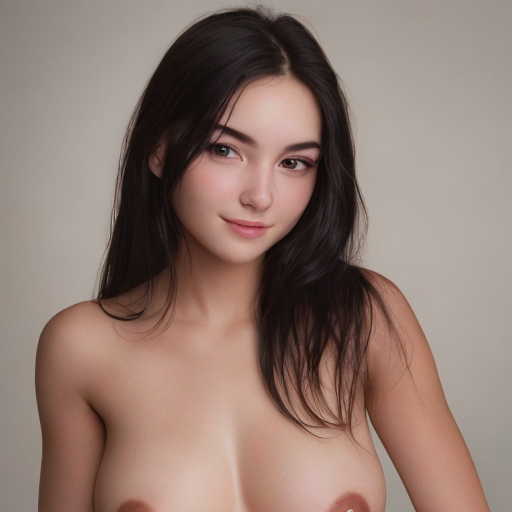

In [13]:
image = run_pipe(
    pipe,
    prompts[0],
    batch_size=1,
    pref="inpaint",
    # image=original_image,
    # mask_image=mask,
)
load_image(image[0])